# Project 3: Clustering and Phylogeny
Nikita Kozlov 317099

The goal of the project is to conduct a comprehensive phylogenetic analysis and submit a report
with a detailed description of the methods applied, the datasets used, and the results obtained.

## Running MSA on all obtained sequences

In [213]:
import os
import random

fasta_files = [f for f in os.listdir('proteins') if f.endswith('.fasta')]
fasta_files

['1PPF_E.fasta',
 'NP_570139.3.fasta',
 'CAA84380.1.fasta',
 'AAB50706.1.fasta',
 'AAB03393.1.fasta',
 'AAA63214.1.fasta',
 'AAA59172.1.fasta',
 'NP_001381685.1.fasta']

In [165]:
merged_fasta = 'data/merged.fasta'

In [214]:
# Load all fasta files
from Bio import SeqIO

records = []
for fasta_file in fasta_files:
    for record in SeqIO.parse(f'proteins/{fasta_file}', 'fasta'):
        records.append(record)

In [215]:
# Write the merged fasta file
with open(merged_fasta, 'w') as f:
    for record in records:
        SeqIO.write(record, f, 'fasta')

# Check the merged file - by counting the number of sequences
!grep -c '>' data/merged.fasta

64


In [216]:
# Run MUSCLE
!muscle -align data/merged.fasta -output data/msa.fasta


muscle 5.3.osxarm64 [-]  17.2Gb RAM, 12 cores
Built Dec 12 2024 04:49:44
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

[align data/merged.fasta]
Input: 64 seqs, avg length 337, max 678, min 108

00:00 5.1Mb   100.0% Derep 64 uniques, 0 dupes
00:00 5.3Mb  CPU has 12 cores, running 12 threads
00:04 415Mb   100.0% Calc posteriors
00:04 415Mb   100.0% UPGMA5         
00:08 367Mb   100.0% Consistency (1/2)(1/2)
00:11 289Mb   100.0% Consistency (2/2)
        00:12 321Mb   100.0% Refining


In [217]:
# Create a distance matrix

import pickle

from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator

# Load the MSA
alignment = AlignIO.read('data/msa.fasta', 'fasta')

# Calculate the distance matrix
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

# Save the distance matrix
with open('data/dm_matrix.pkl', 'wb') as f:
    pickle.dump(dm, f)

## Clustering the sequences using CD-HIT

In [218]:
!cd-hit -i data/merged.fasta -o data/clusters -c 0.5 -n 2

Program: CD-HIT, V4.8.1, Dec 10 2024, 20:54:33
Command: cd-hit -i data/merged.fasta -o data/clusters -c 0.5
         -n 2

Started: Wed Dec 18 14:32:54 2024
                            Output                              
----------------------------------------------------------------
total seq: 64
longest and shortest : 678 and 108
Total letters: 21589
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 16M = 16M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 16M

Table limit with the given memory limit:
Max number of representatives: 1336018
Max number of word counting entries: 97976564

comparing sequences from          0  to         64

       64  finished          8  clusters

Approximated maximum memory consumption: 16M
writing new database
writing clustering information
program completed !

Total CPU time 0.01


In [219]:
# Check the number of clusters
!grep -c '>Cluster' data/clusters.clstr

8


## Building a phylogenetic tree using Bio.Phylo.TreeConstruction

### separate tree for each "group" of proteins

In [284]:
import re

dm_matrix = 'data/dm_matrix.pkl'

# Load the distance matrix
with open(dm_matrix, 'rb') as f:
    dm = pickle.load(f)

records_metadata = {}
for record in records:
    records_metadata[record.id] = {
        'name': re.sub(r'\[.*\]', '', record.description).replace(record.id, '').strip(),
        'organism': re.search(r'\[(.*)\]', record.description).group(1)
    }

# Load the groups
groups = {}
fasta_files = [f for f in os.listdir('proteins') if f.endswith('.fasta')]
for fasta_file in fasta_files:
    group = fasta_file.split('.')[0]
    groups[group] = []
    for record in SeqIO.parse(f'proteins/{fasta_file}', 'fasta'):
        groups[group].append({
            'id': record.id,
            'name': records_metadata[record.id]['name'],
            'organism': records_metadata[record.id]['organism']
        })

# Load the cluster file
clusters = {}
with open('data/clusters.clstr') as f:
    cluster_id = None
    for line in f:
        if line.startswith('>'):
            cluster_id = line.strip().replace('>', '')
            clusters[cluster_id] = []
        else:
            cluster_member_id = line.split('>')[1].split('...')[0]
            clusters[cluster_id].append({
                'id': cluster_member_id,
                'name': records_metadata[cluster_member_id]['name'],
                'organism': records_metadata[cluster_member_id]['organism']
            })

print(f'Length of groups: {len(groups)}')
print(f'Length of clusters: {len(clusters)}')

Length of groups: 8
Length of clusters: 8


In [309]:
def create_sub_dm_with_organism_labels(parent_dm, members):
    sub_dm = DistanceMatrix(names=[member['id'] for member in members])
    for member1 in members:
        for member2 in members:
            name1 = member1['id']
            name2 = member2['id']

            sub_dm[name1, name2] = parent_dm[name1, name2]

    # Rename the nodes to organism names
    sub_dm.names = [member['organism'] for member in members]

    return sub_dm

def draw_group_tree(tree):
    plt.figure(figsize=(10, 10))
    Phylo.draw(
        tree,
        axes=plt.gca(),
        branch_labels=lambda c: round(c.branch_length, 3),
        label_func=lambda n: n.name if n.is_terminal() else '',
        do_show=False
    )

    return tree

def draw_full_tree(tree, records_metadata):
    plt.figure(figsize=(30, 30))
    Phylo.draw(
        tree,
        axes=plt.gca(),
        label_func=lambda n: (
            f"{records_metadata[n.name]['name']} {records_metadata[n.name]['organism']}"
            if n.is_terminal()
            else ''
        ),
        do_show=False
    )

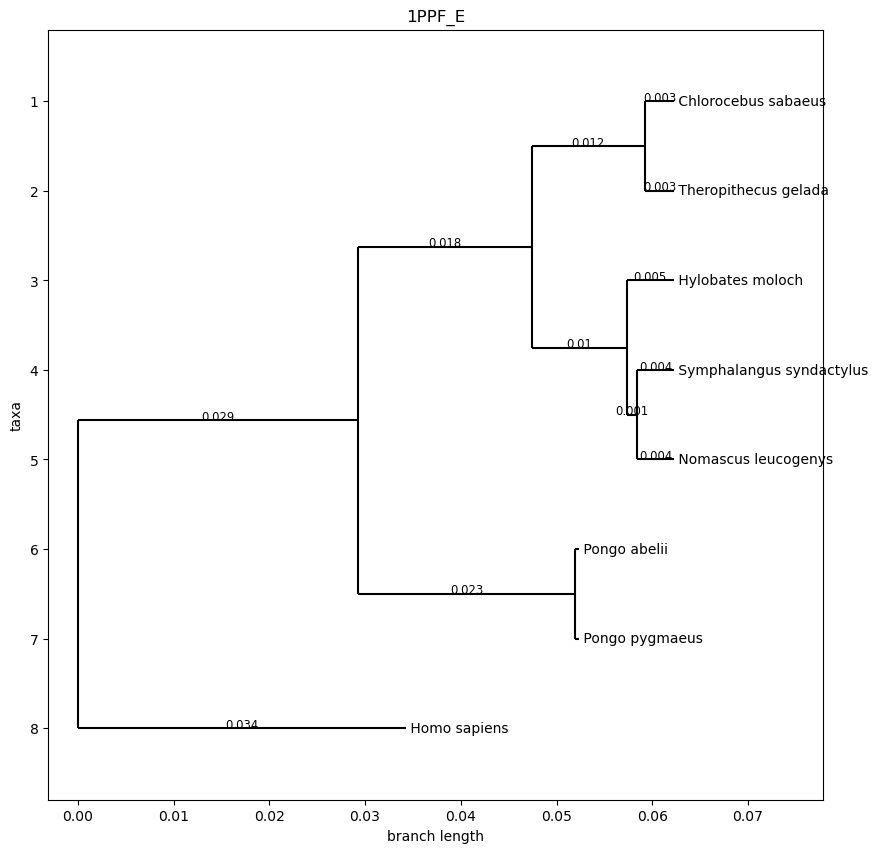

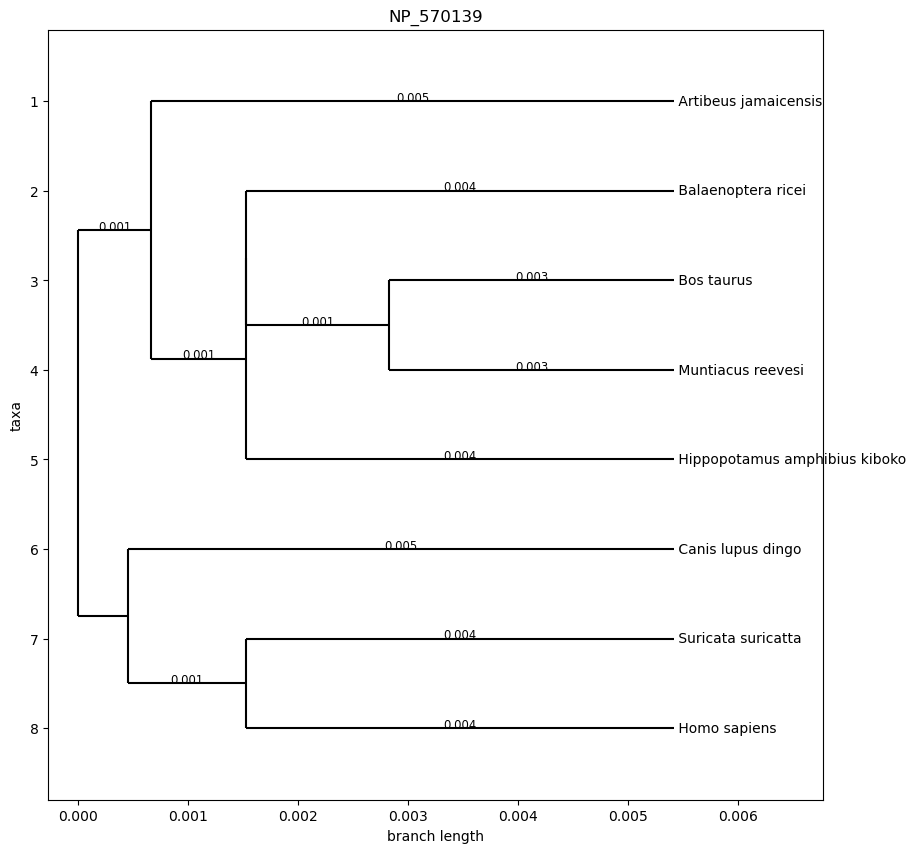

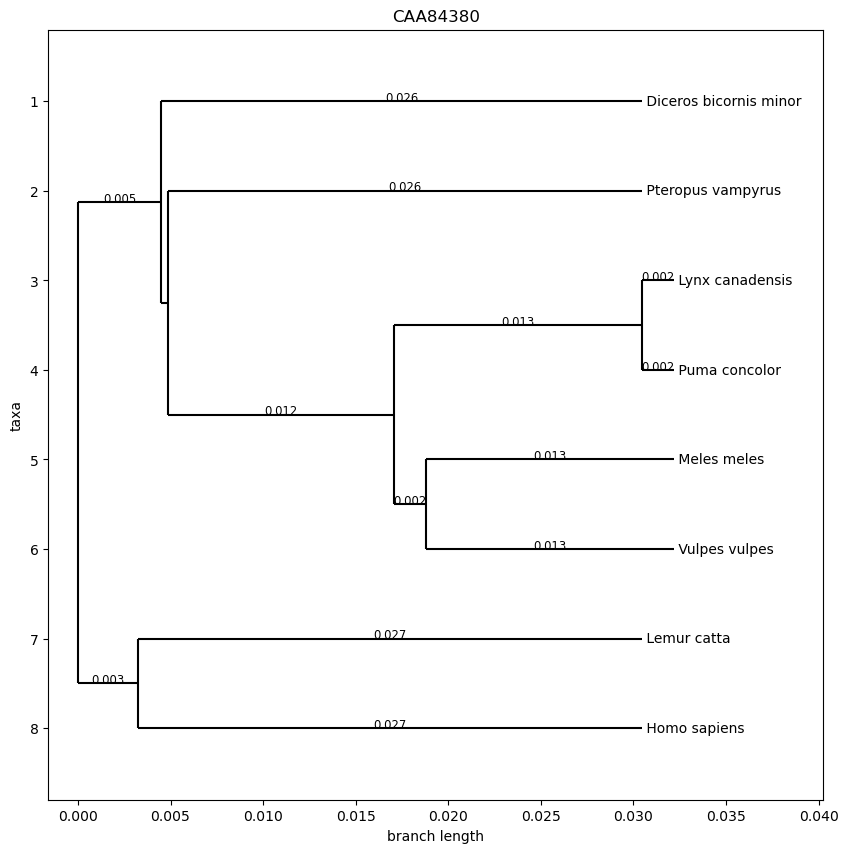

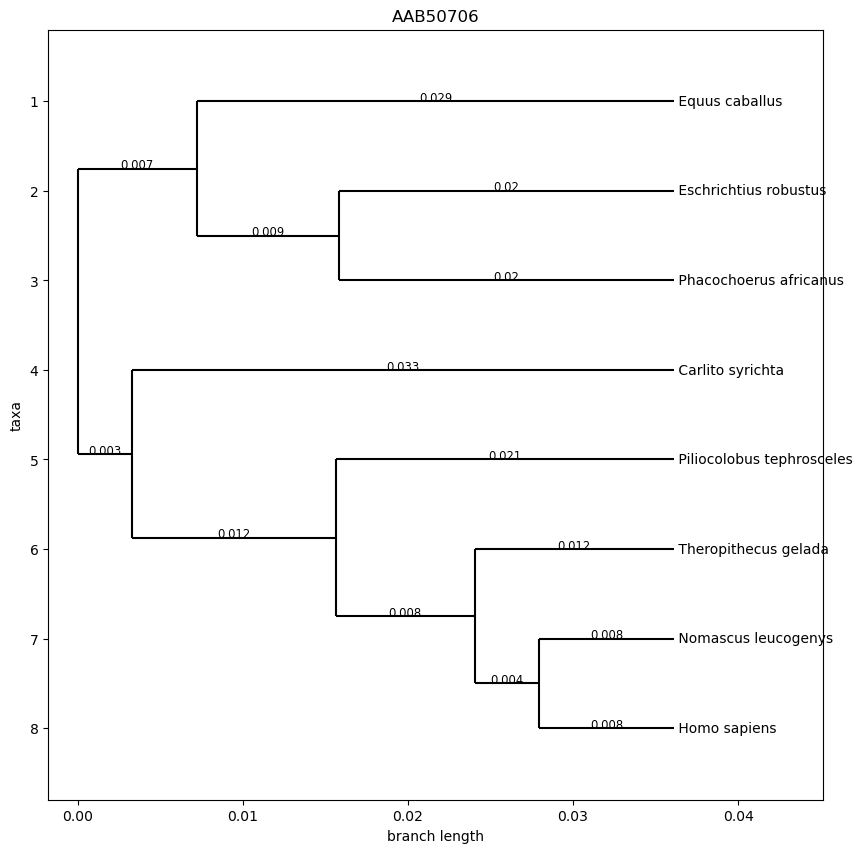

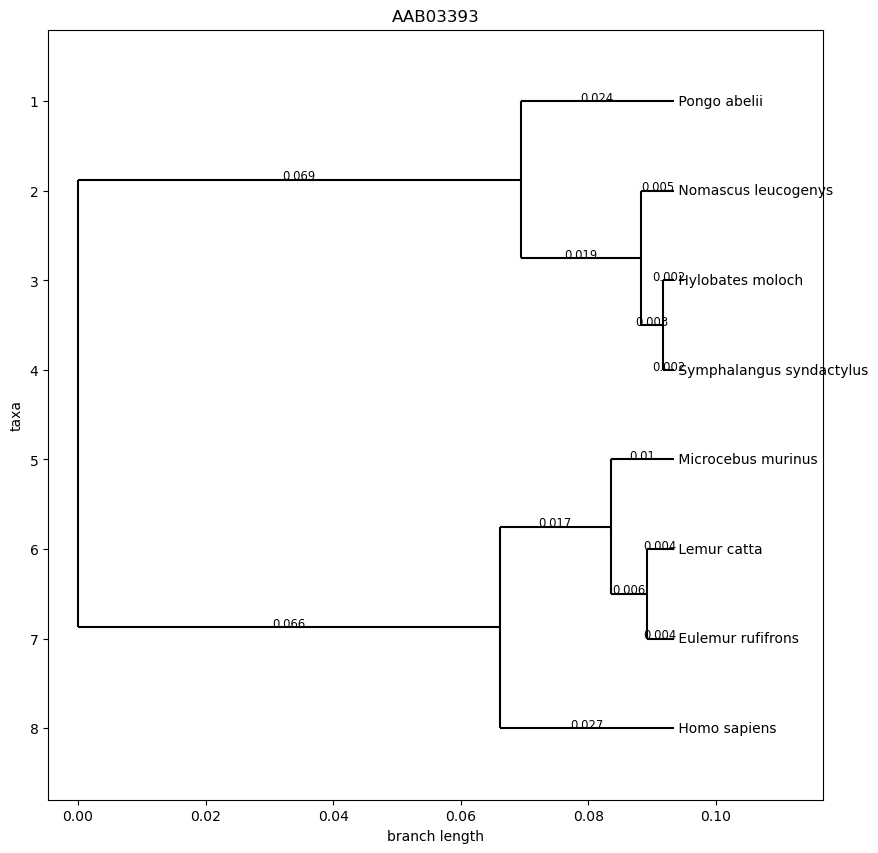

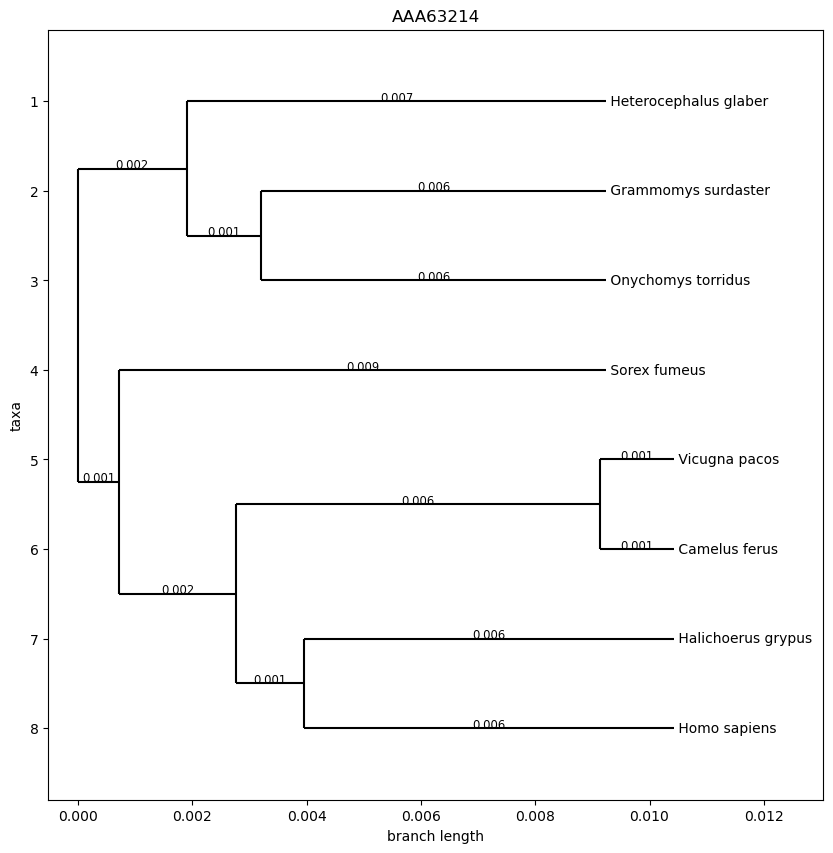

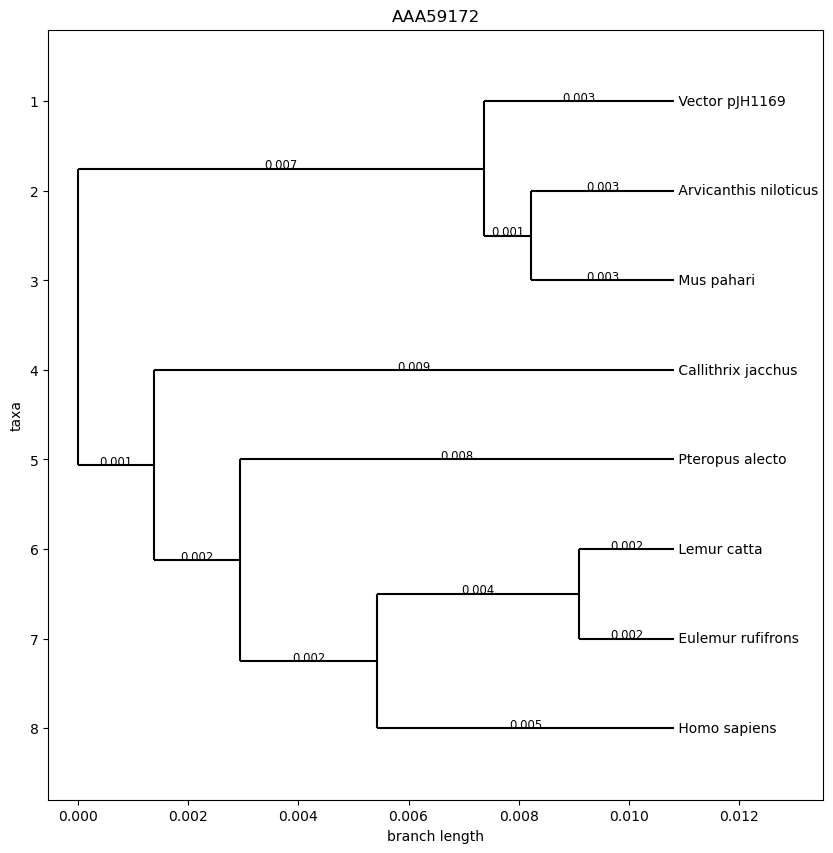

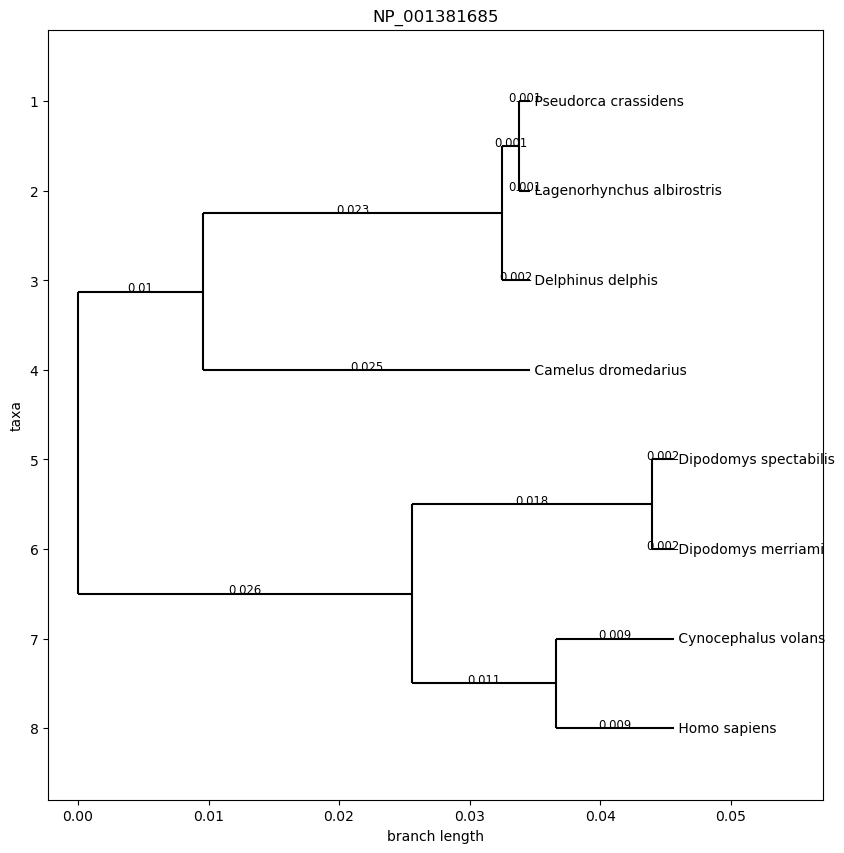

In [311]:
from matplotlib import pyplot as plt
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix

constructor = DistanceTreeConstructor()
trees = {}

for group, members in groups.items():
    sub_dm = create_sub_dm_with_organism_labels(dm, members)

    tree = constructor.upgma(sub_dm)
    trees[group] = tree

    # Draw the tree
    draw_group_tree(tree)
    plt.title(group)
    plt.savefig(f'data/trees/{group}.png')
    plt.show()

    # Save the tree
    Phylo.write(tree, f'data/trees/{group}.tree', 'newick')


### separate tree for each cluster

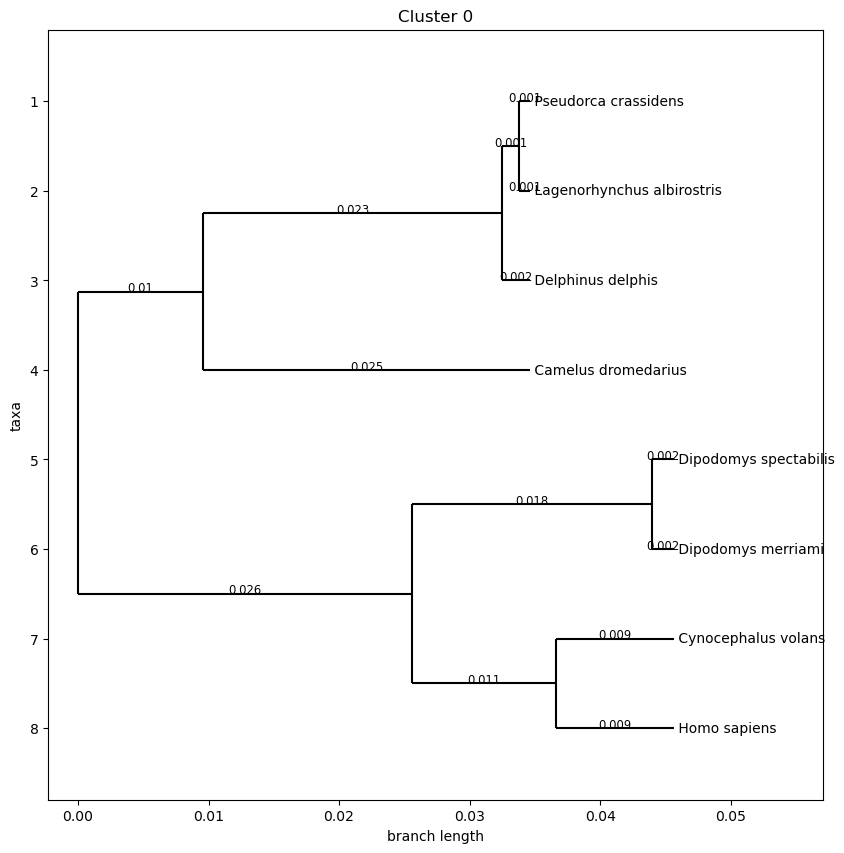

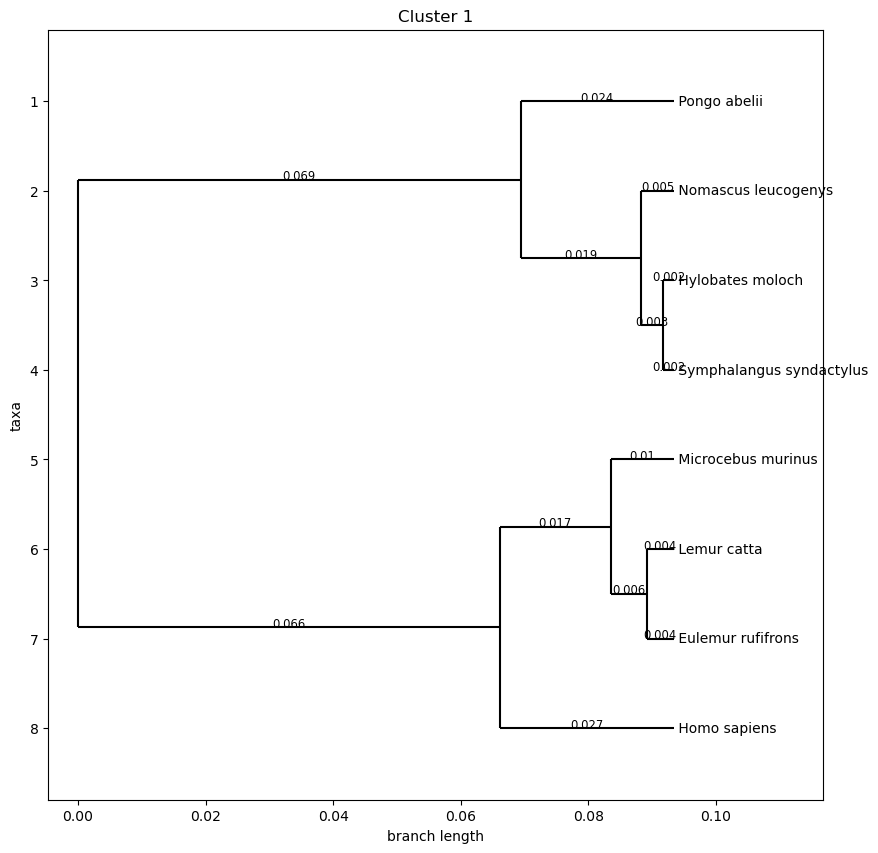

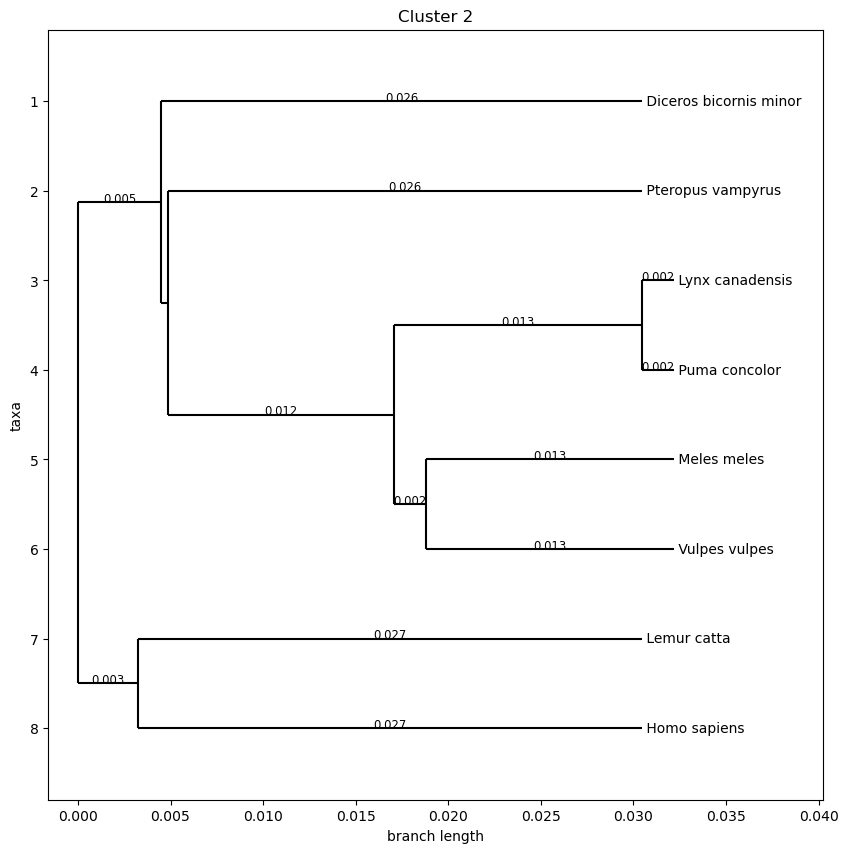

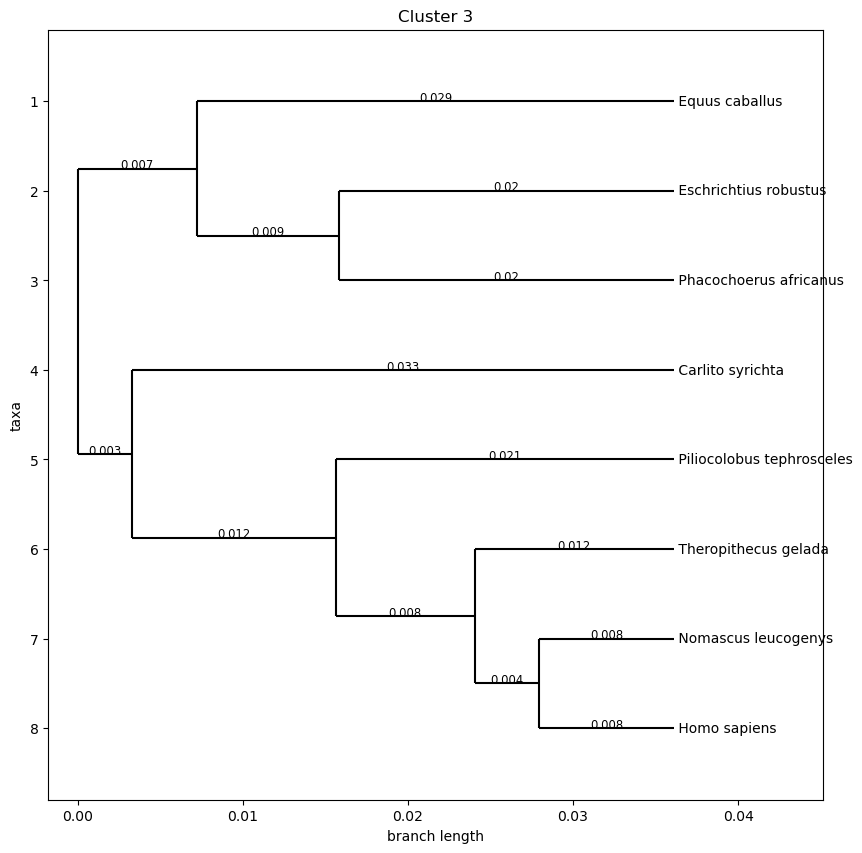

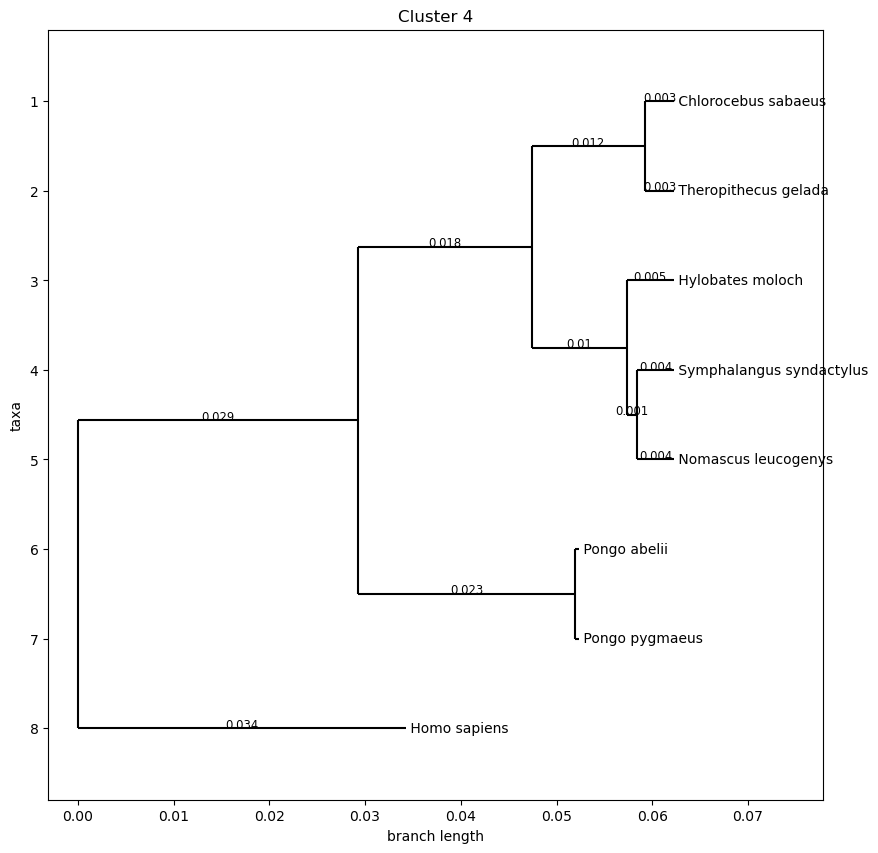

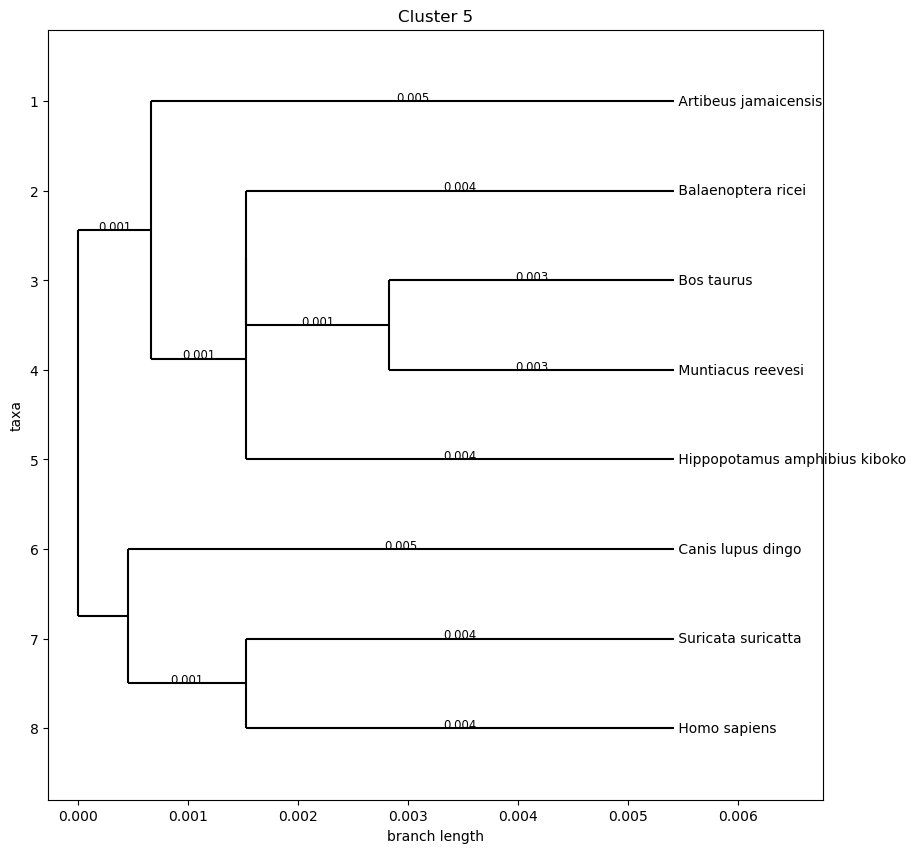

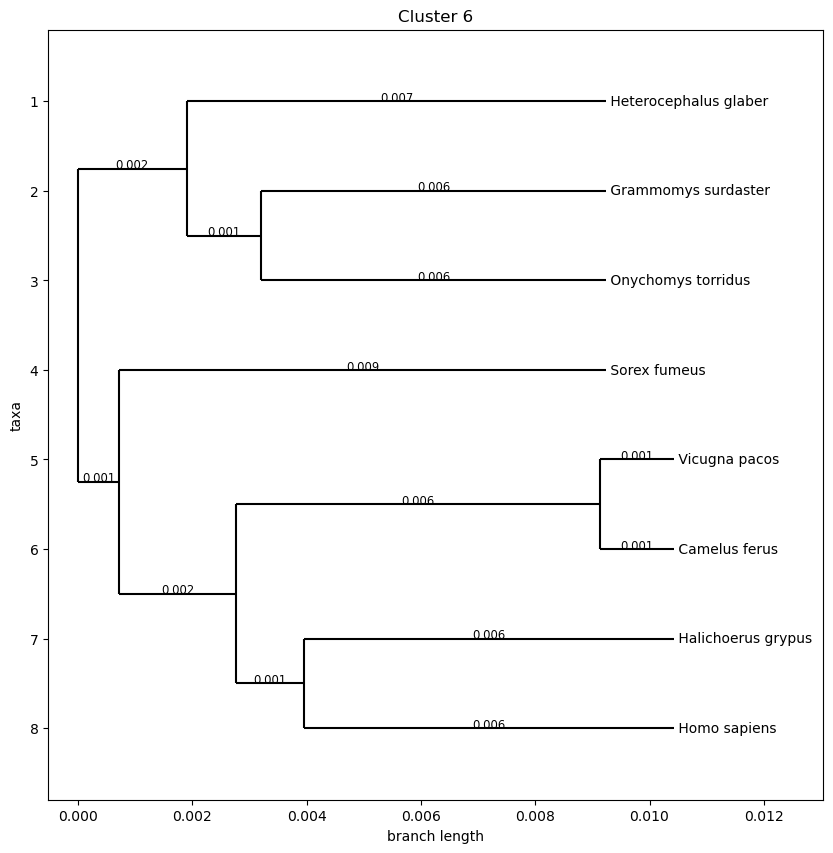

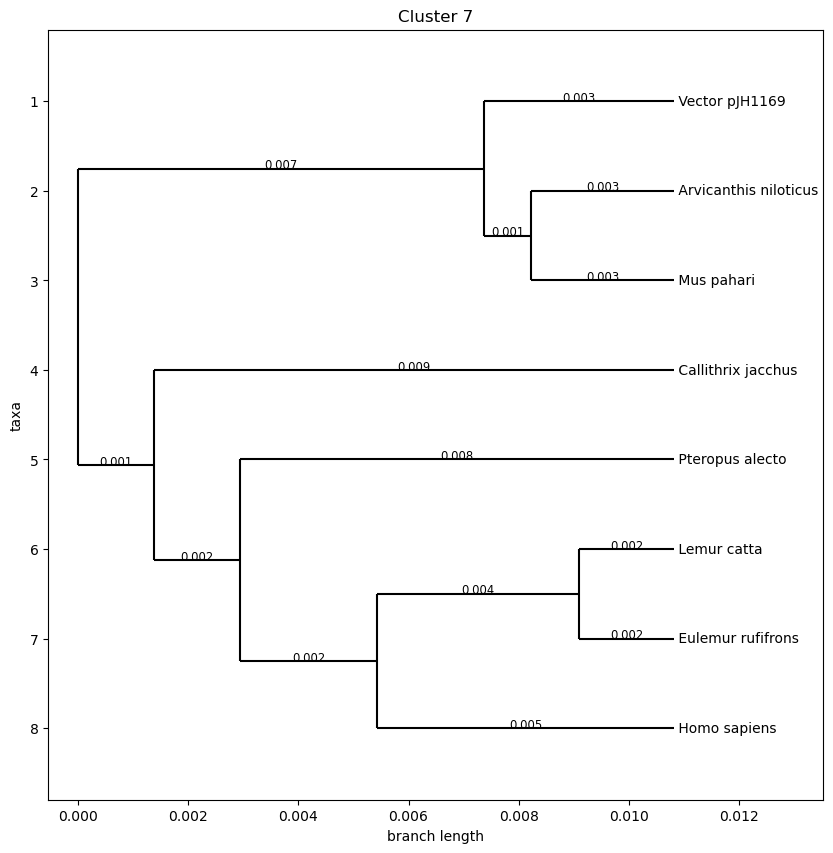

In [312]:
for cluster_id, members in clusters.items():
    sub_dm = create_sub_dm_with_organism_labels(dm, members)

    tree = constructor.upgma(sub_dm)
    trees[cluster_id] = tree

    draw_group_tree(tree)
    plt.title(cluster_id)
    plt.savefig(f'data/trees/{cluster_id}.png')
    plt.show()

    # Save the tree
    Phylo.write(tree, f'data/trees/{cluster_id}.tree', 'newick')

### one common tree for all downloaded sequences

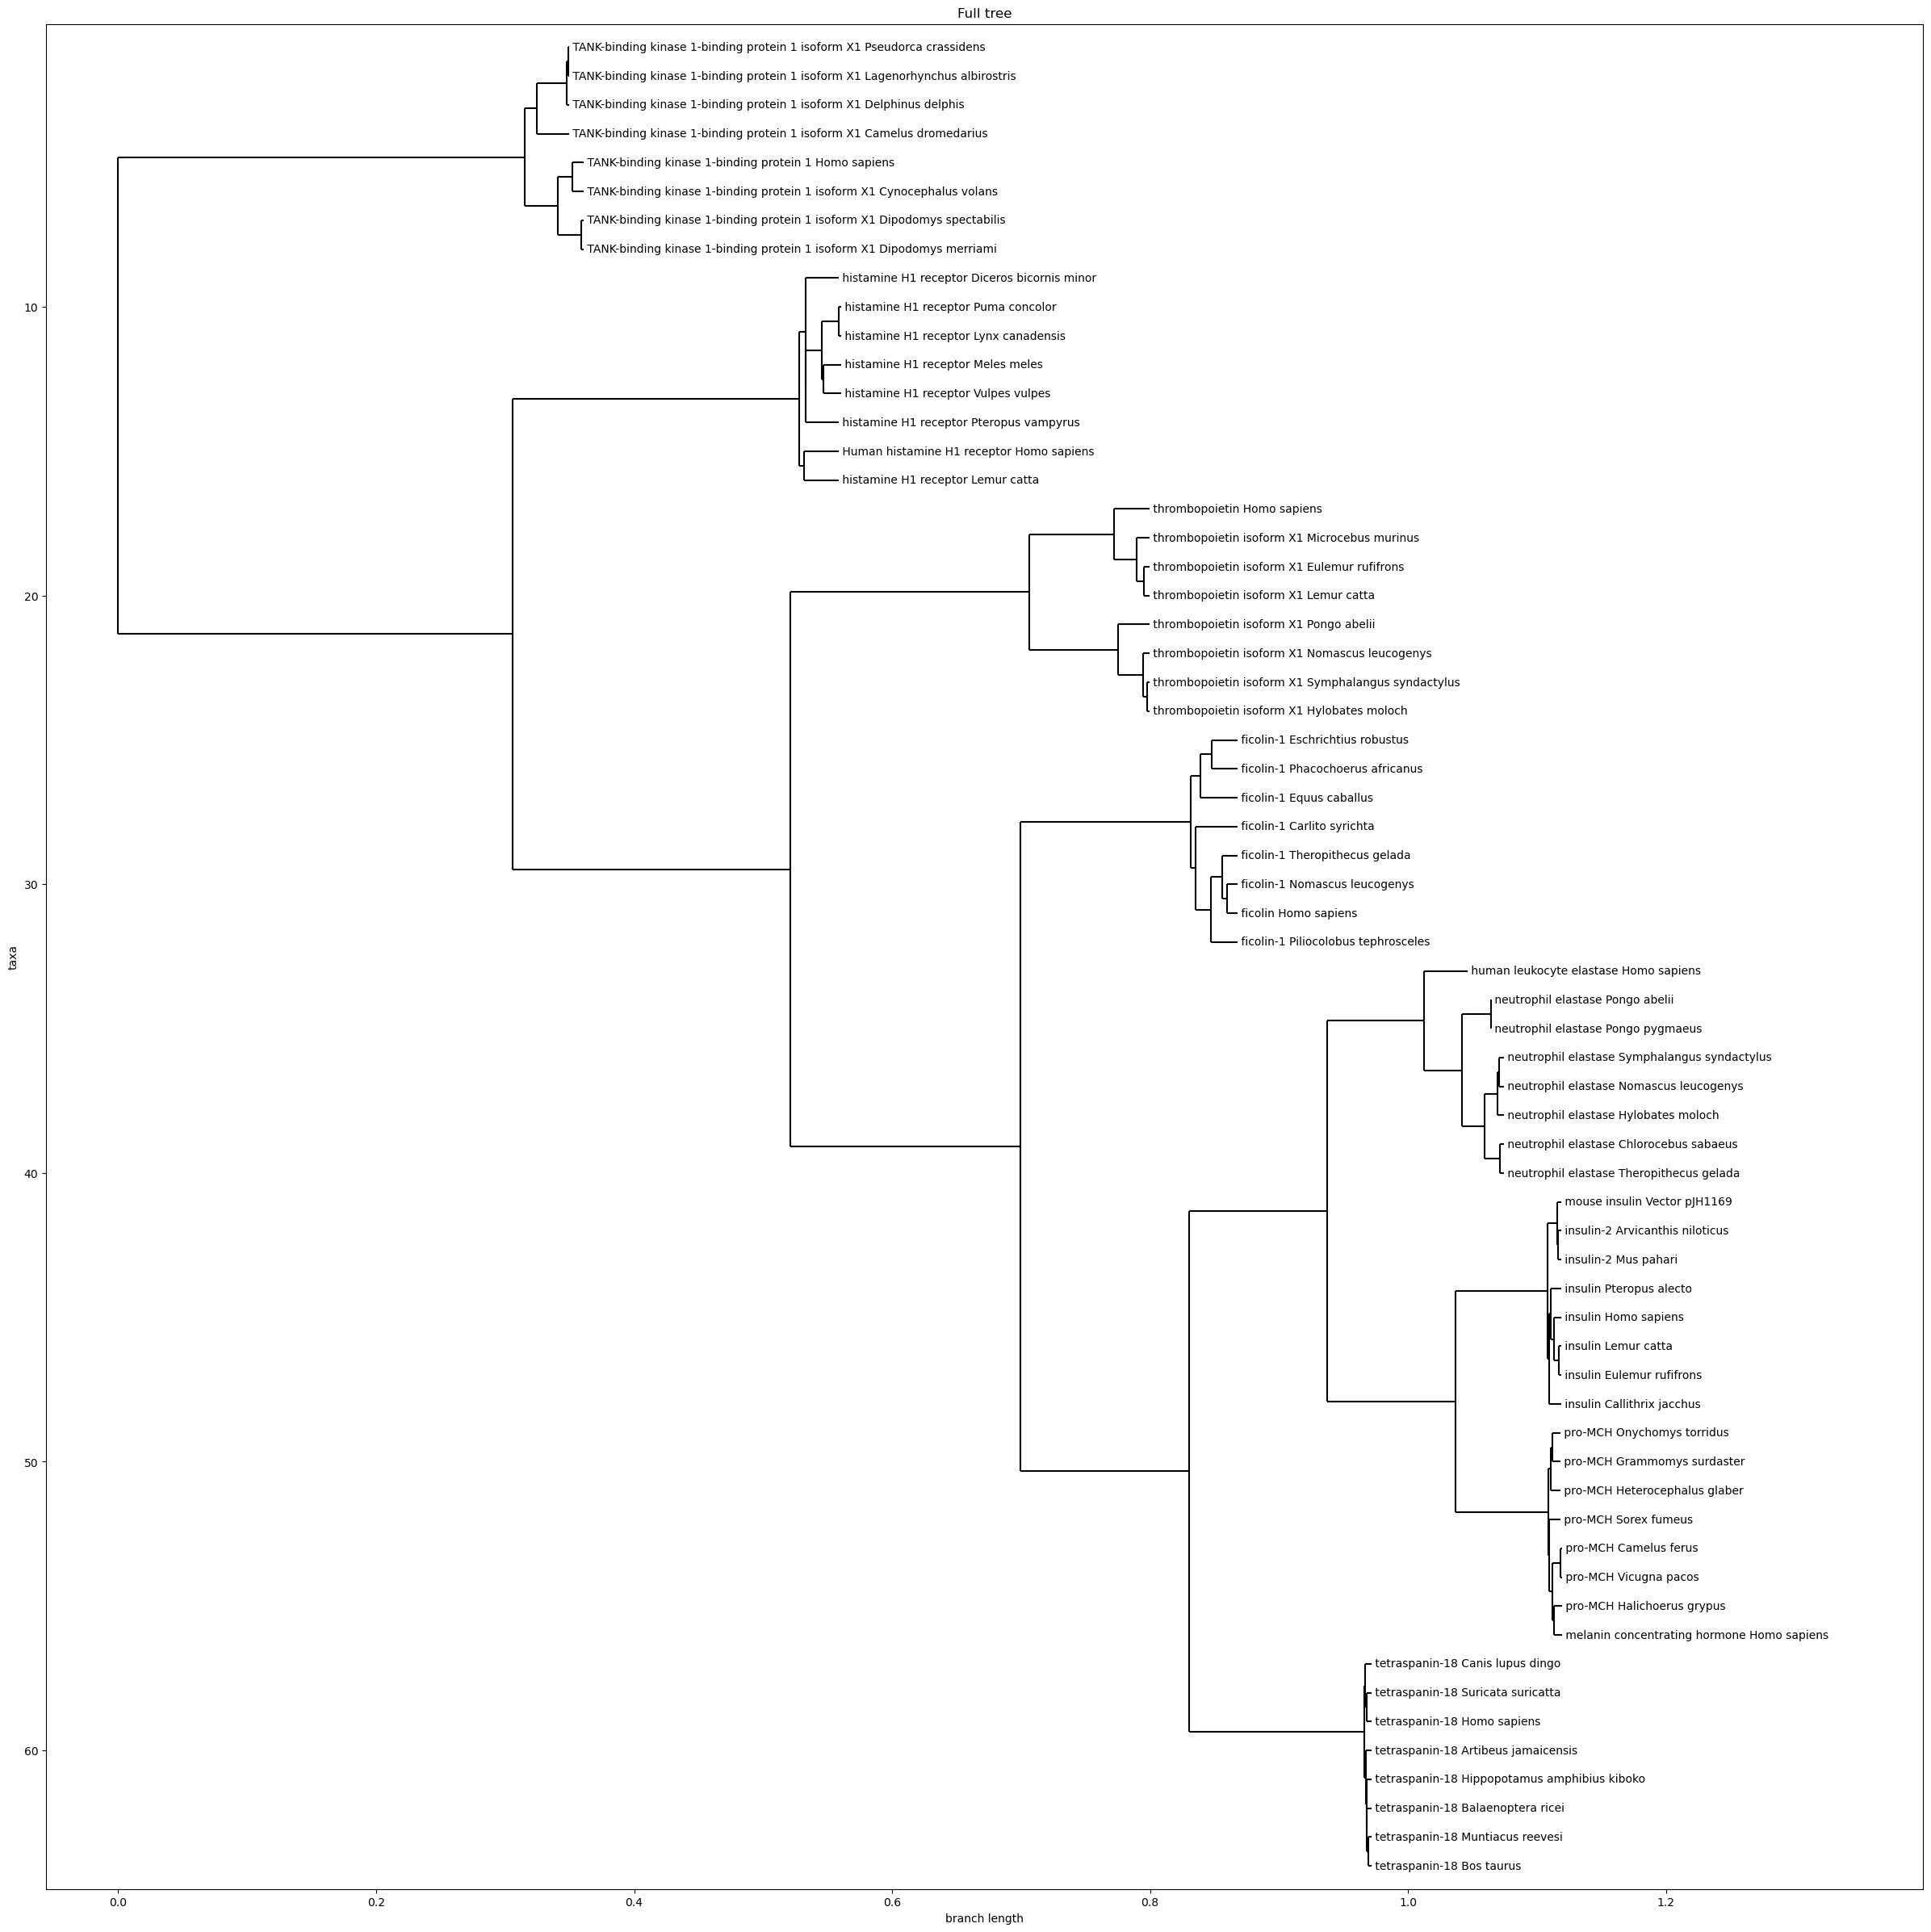

1

In [318]:
tree = constructor.upgma(dm)
draw_full_tree(tree, records_metadata)
plt.title('Full tree')
plt.savefig('data/trees/full.png')
plt.show()

Phylo.write(tree, 'data/trees/full.tree', 'newick')

### consensus trees from two approaches (clusters vs. the groups of proteins downloaded together).

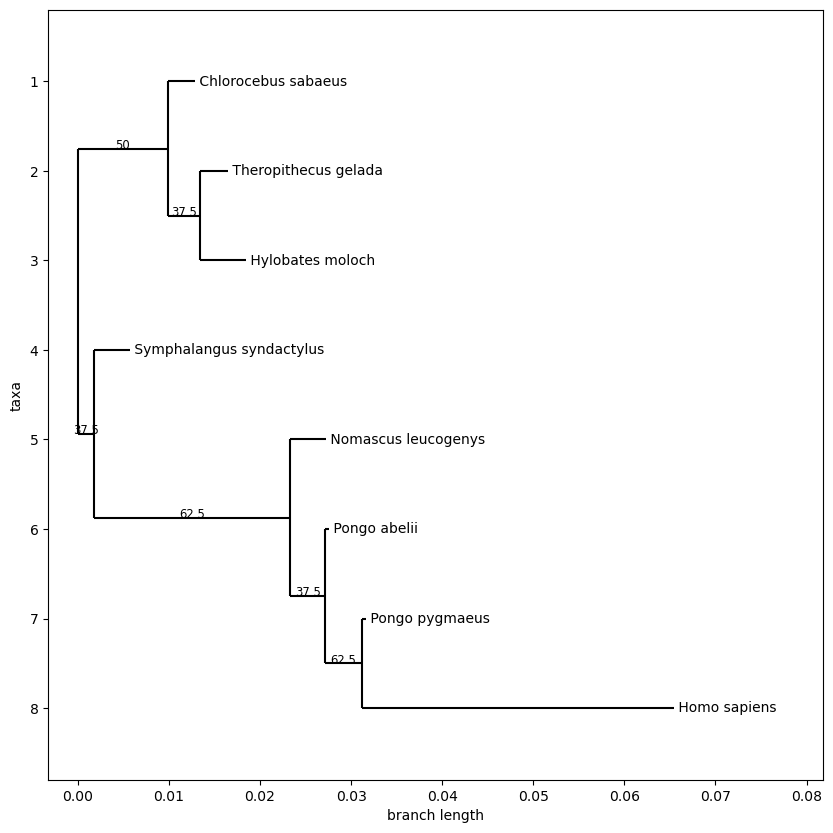

1

In [316]:
from Bio.Phylo.Consensus import majority_consensus

# Consensus tree for the groups
group_trees = [trees[group] for group in groups.keys()]
group_majority = majority_consensus(group_trees)

plt.figure(figsize=(10, 10))
Phylo.draw(group_majority, axes=plt.gca(), label_func=lambda n: n.name if n.is_terminal() else '', do_show=False)
plt.savefig('data/trees/groups_consensus.png')
plt.show()

Phylo.write(group_majority, 'data/trees/groups_consensus.tree', 'newick')

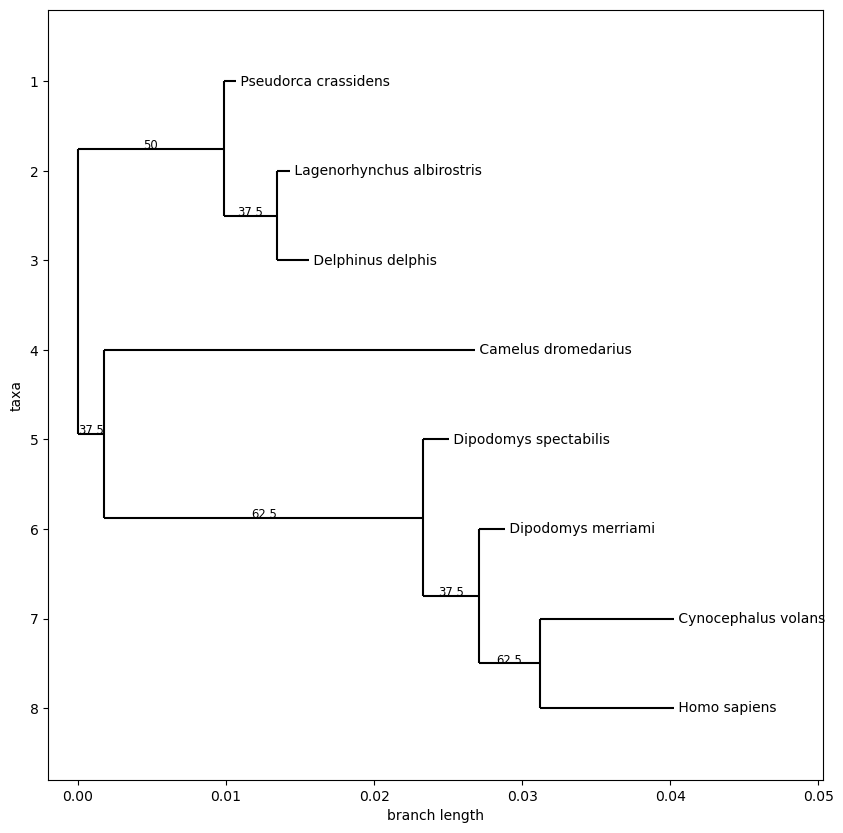

1

In [317]:
# Consensus tree for the clusters
cluster_trees = [trees[cluster_id] for cluster_id in clusters.keys()]
cluster_majority = majority_consensus(cluster_trees)

plt.figure(figsize=(10, 10))
Phylo.draw(cluster_majority, axes=plt.gca(), label_func=lambda n: n.name if n.is_terminal() else '', do_show=False)
plt.savefig('data/trees/clusters_consensus.png')
plt.show()

Phylo.write(cluster_majority, 'data/trees/clusters_consensus.tree', 'newick')

## Coloring the tree

### Color tree branches based on the organism

In [358]:
import copy
import random

all_organsims = set([records_metadata[record.id]['organism'] for record in records])
print(f'Number of unique organisms: {len(all_organsims)}')

organism_colors = {}
with open('data/colors.txt', 'r') as f:
    all_colors = f.read().split('\n')
    for i, organism in enumerate(all_organsims):
        organism_colors[organism] = all_colors[i % len(all_colors)]

record_id_by_organizm_colors = {
    record.id: organism_colors[records_metadata[record.id]['organism']]
    for record in records
}

record_id_by_group_colors = {}
for i, (group, members) in enumerate(groups.items()):
    color = random.choice(all_colors)
    for member in members:
        record_id_by_group_colors[member['id']] = color


Number of unique organisms: 48


In [356]:
def color_organism_labeled_tree(tree, organism_colors):
    tree_cloned = copy.deepcopy(tree)

    for clade in tree_cloned.find_clades():
        if clade.name in organism_colors:
            clade.color = organism_colors[clade.name]

    return tree_cloned

def color_record_id_labeled_tree_by_organism(tree, record_id_by_organizm_colors):
    tree_cloned = copy.deepcopy(tree)

    for clade in tree_cloned.find_clades():
        if clade.name in record_id_by_organizm_colors:
            clade.color = record_id_by_organizm_colors[clade.name]

    return tree_cloned

def color_record_id_labeled_tree_by_group(tree, record_id_by_group_colors):
    tree_cloned = copy.deepcopy(tree)

    for clade in tree_cloned.find_clades():
        if clade.name in record_id_by_group_colors:
            clade.color = record_id_by_group_colors[clade.name]

    return tree_cloned

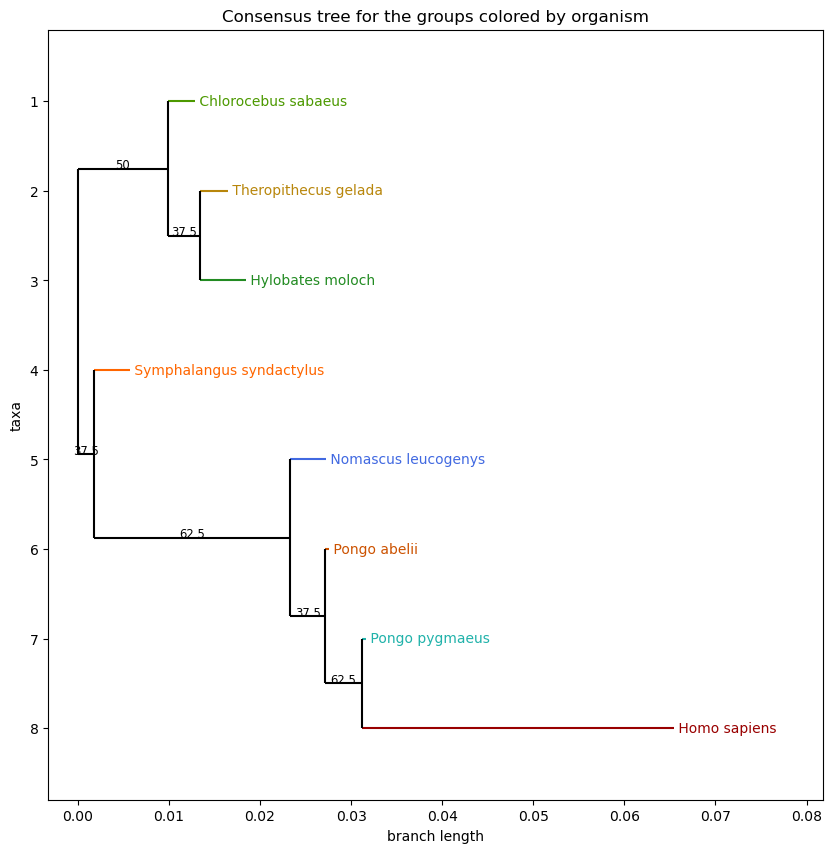

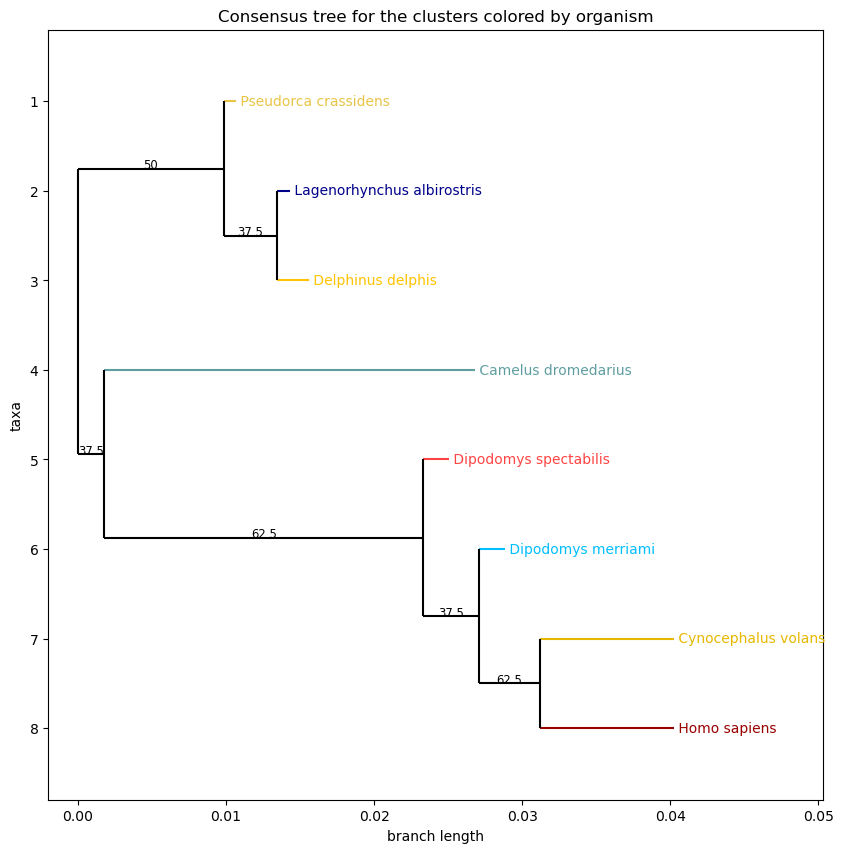

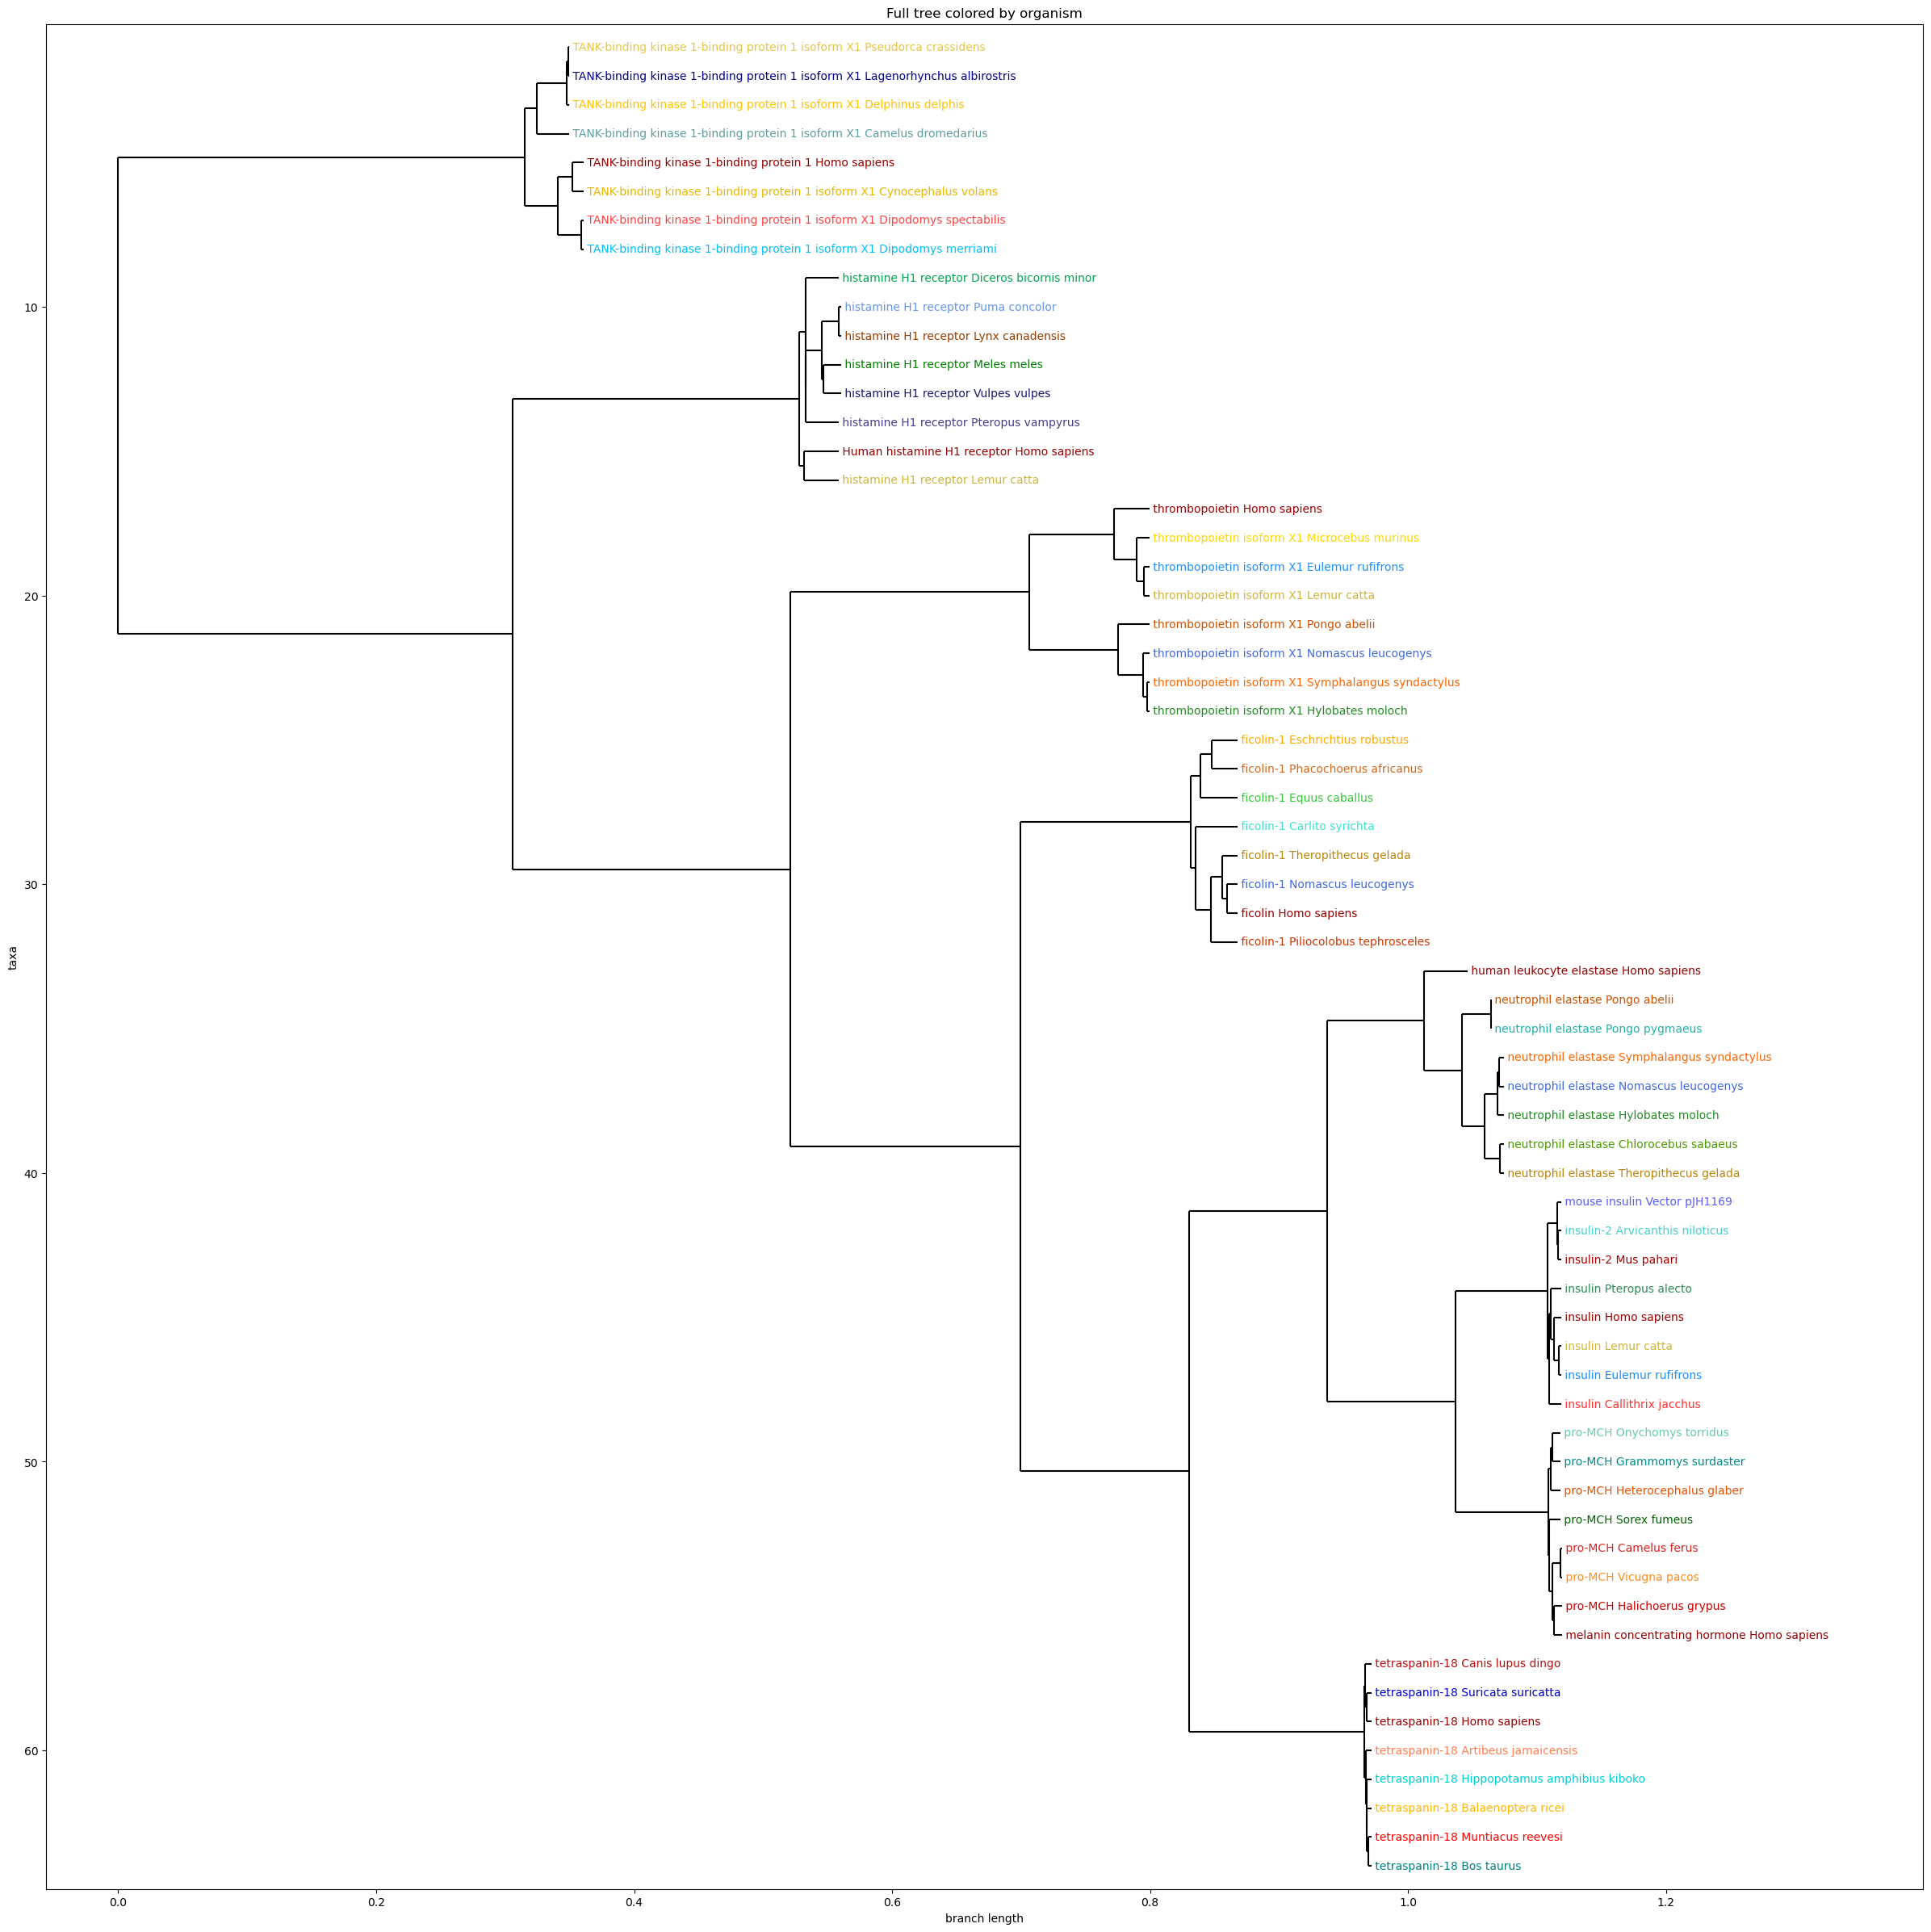

In [353]:
# Color consensus tree for the groups
group_majority_colored = color_organism_labeled_tree(group_majority, organism_colors)
plt.figure(figsize=(10, 10))
Phylo.draw(group_majority_colored, axes=plt.gca(), label_func=lambda n: n.name if n.is_terminal() else '', do_show=False, label_colors=organism_colors)
plt.title('Consensus tree for the groups colored by organism')
plt.savefig('data/trees/groups_consensus_colored.png')
plt.show()


# Color consensus tree for the clusters
cluster_majority_colored = color_organism_labeled_tree(cluster_majority, organism_colors)
plt.figure(figsize=(10, 10))
Phylo.draw(cluster_majority_colored, axes=plt.gca(), label_func=lambda n: n.name if n.is_terminal() else '', do_show=False, label_colors=organism_colors)
plt.title('Consensus tree for the clusters colored by organism')
plt.savefig('data/trees/clusters_consensus_colored.png')

# Color full tree
tree_colored = color_record_id_labeled_tree_by_organism(tree, organism_colors)
plt.figure(figsize=(30, 30))
Phylo.draw(
    tree_colored,
    axes=plt.gca(),
    label_func=lambda n: (
        f"{records_metadata[n.name]['name']} {records_metadata[n.name]['organism']}"
        if n.is_terminal()
        else ''
    ),
    do_show=False,
    label_colors={
        f"{records_metadata[record_id]['name']} {records_metadata[record_id]['organism']}": color
        for record_id, color in record_id_by_organizm_colors.items()
    }
)
plt.title('Full tree colored by organism')
plt.savefig('data/trees/full_colored.png')


### Color tree branches based on the protein "group"

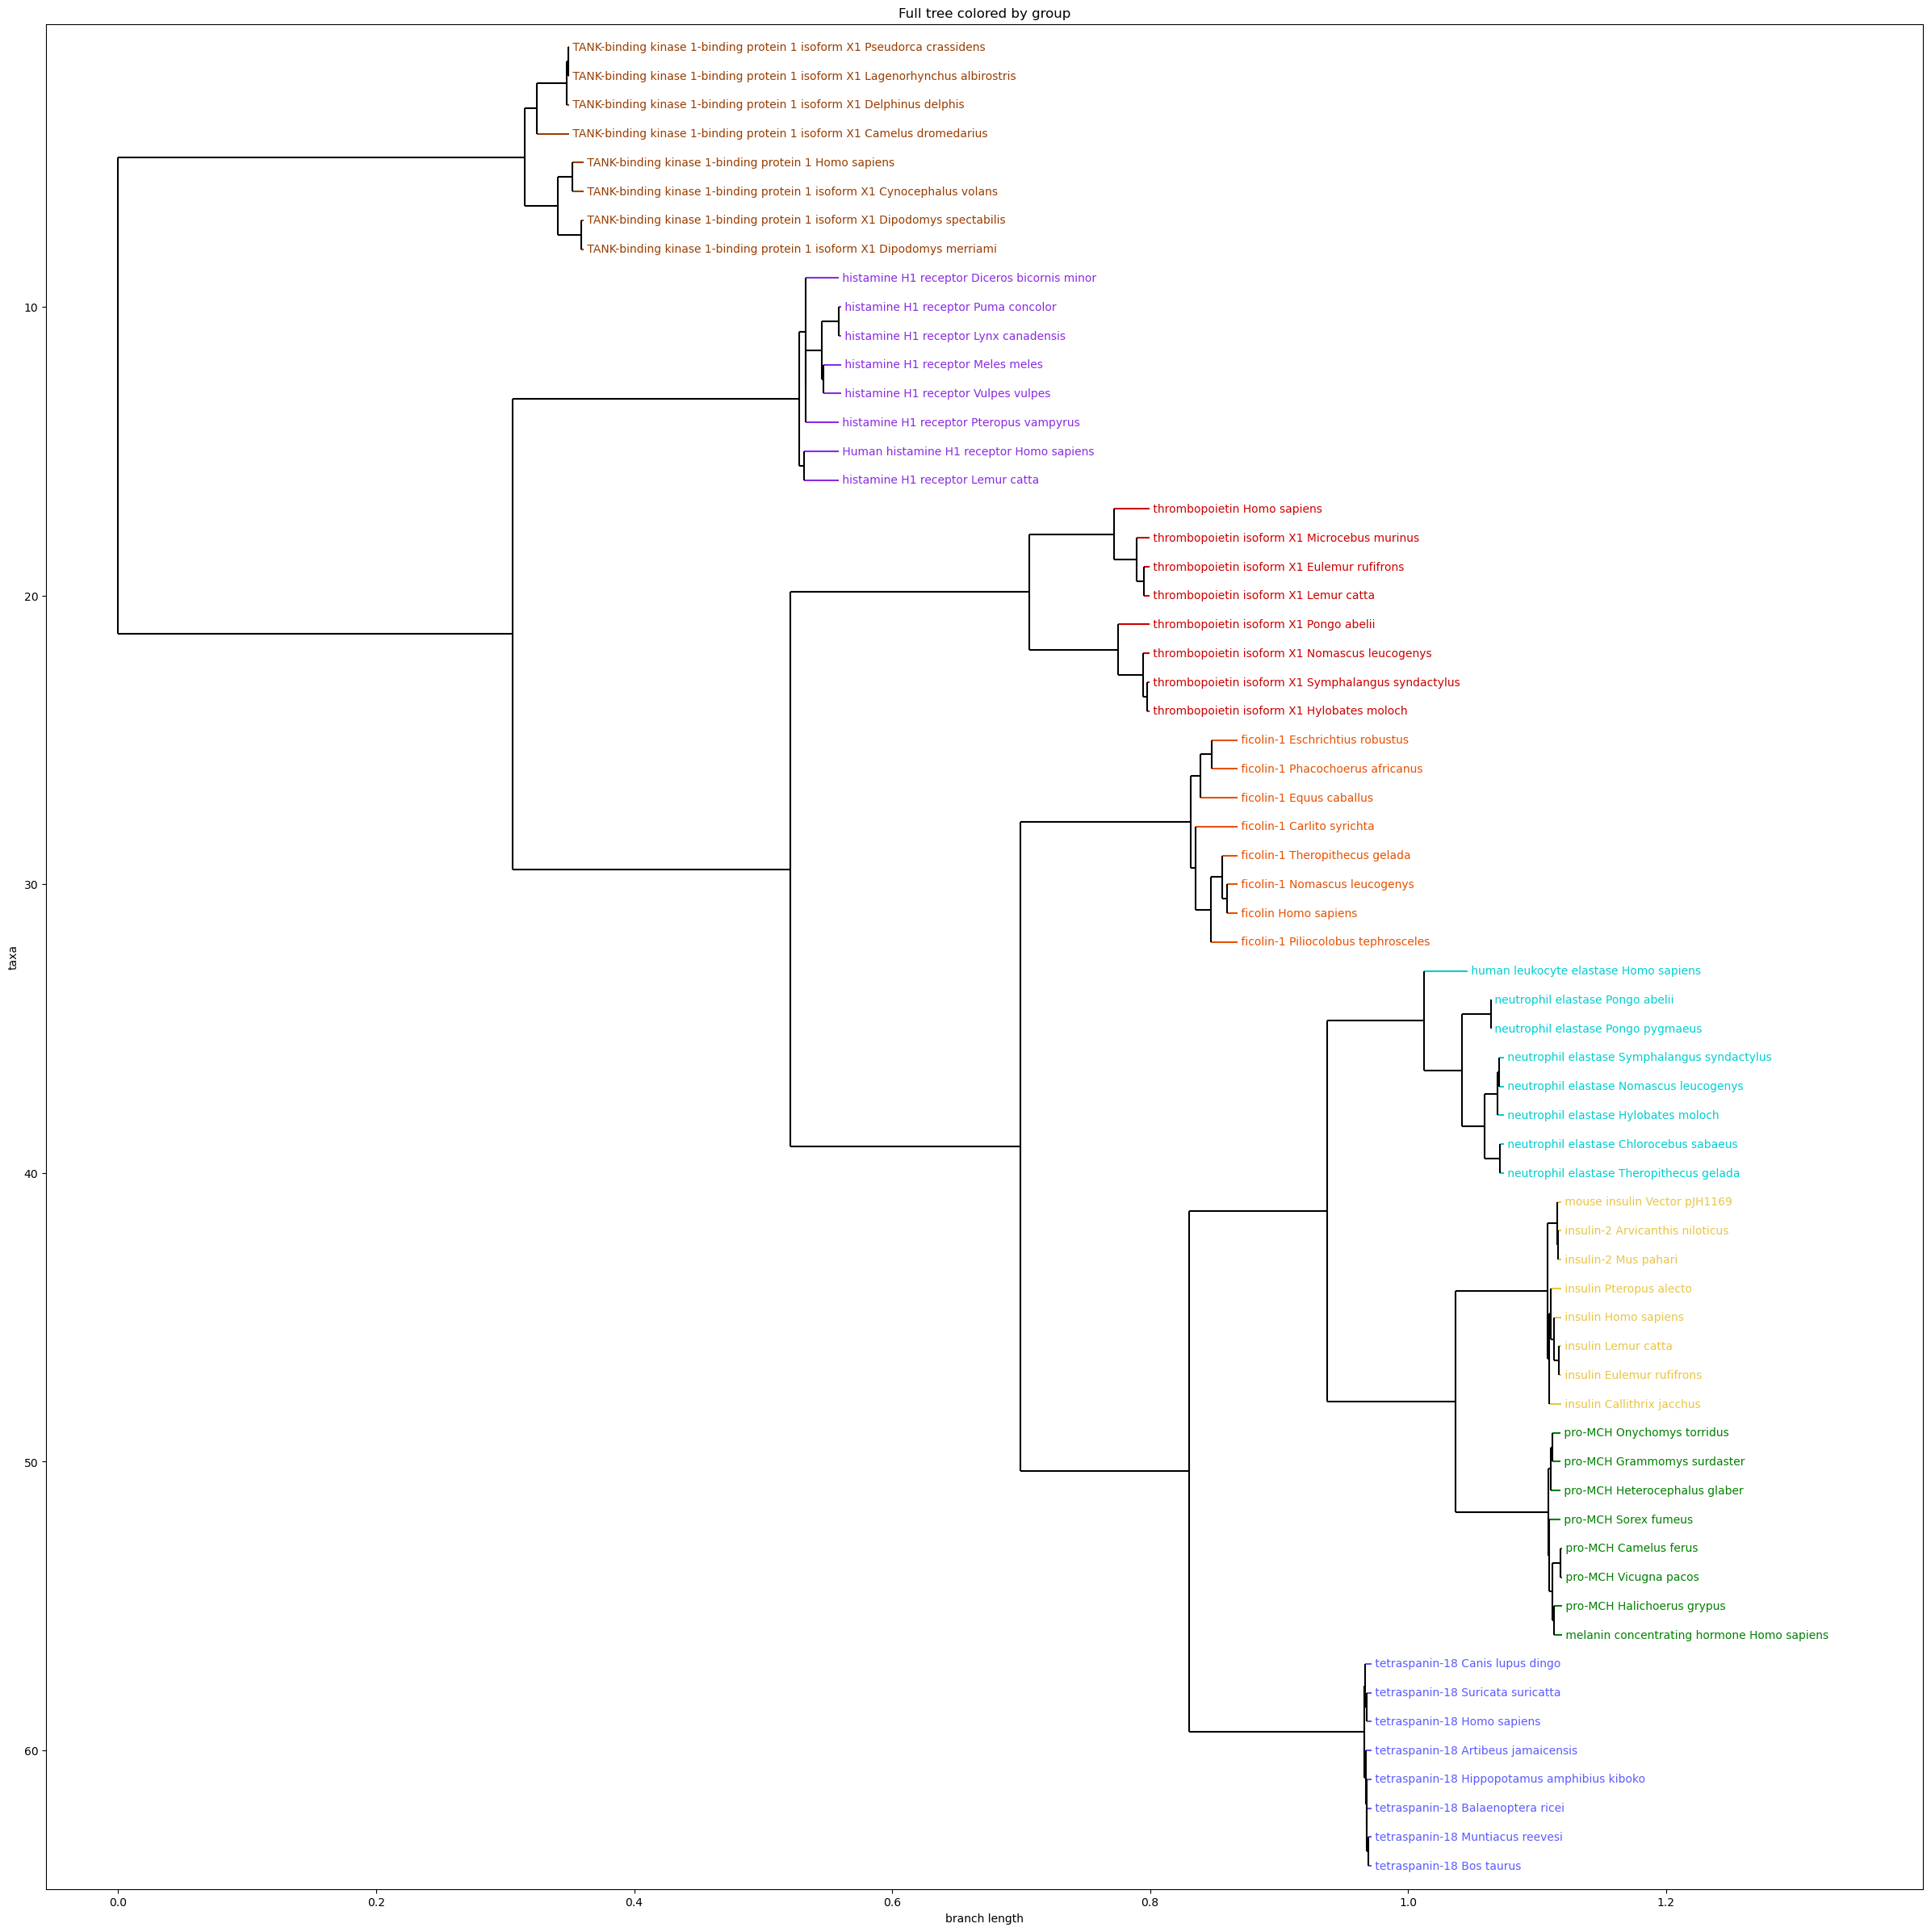

In [359]:
# Color full tree by group
tree_colored = color_record_id_labeled_tree_by_group(tree, record_id_by_group_colors)
plt.figure(figsize=(30, 30))
Phylo.draw(
    tree_colored,
    axes=plt.gca(),
    label_func=lambda n: (
        f"{records_metadata[n.name]['name']} {records_metadata[n.name]['organism']}"
        if n.is_terminal()
        else ''
    ),
    do_show=False,
    label_colors={
        f"{records_metadata[record_id]['name']} {records_metadata[record_id]['organism']}": color
        for record_id, color in record_id_by_group_colors.items()
    }
)
plt.title('Full tree colored by group')
plt.savefig('data/trees/full_colored_by_group.png')
plt.show()